In [1]:
# load the pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

from data_loader import load_data

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score


# Homework 4: Explainability

In this homework, we will consider several methods for explaining the outputs of predictive models. We will focus on attribution methods, which try to weight the relitive importance of inputs with respect to making a prediction. It is important to note there are many methods for considering the interactions between variables. This assignment will not consider those methods, because they get complicated quickly. Instead, we will focus on attribution methods such as `LIME`, `Shapley Values`, and `SmoothGrad`.

# Dataset

For this assignment, we will be working with two datasets.

1. `Pima Indians Diabetes Database`: This tabular database has several health diagnostic measures such as blood pressure, and the goal is to predict if a patient has diabetes.

2. `Animal-10N Image Classification Dataset`: The ANIMAL-10N dataset consists of ten classes of animals, comprising 50,000 training images and 5,000 testing images. Your task is to develop a model capable of accurately classifying the animal depicted in a given image.

# Analysis Instructions

## Tabular Data

Starting with the Pima Indians Diabetes Database. This dataset can be downloaded https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

## 1. Investigate the balance of the dataset with respect to the outcome variable. Is the outcome variable of the patient being diabetic undersampled? More specifically, what percentage of the total outcomes have the patient as diabetic? You always want to check this with medical data.

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
print(f"The shape of the diabetes dataset is {df.shape}")

The shape of the diabetes dataset is (768, 9)


The outcome variable for `diabetes` dataset is `Outcome`. The shape of the diabetes dataset is (768, 9). There are 8 variables that could be used to predict `Outcome` that whether or not a patient has a diabetes.

In [4]:
target_count = df['Outcome'].value_counts()/len(df)*100
target_count

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

The percentage of the total outcomes have the patient as diabetic is 34.895833%. The outcome variable of the patient is being diabetic undersampled in this case. 

## 2. Run a linear or logistic model on this dataset with an L1 penalty. What features does the model select on?



In [5]:
# Define X and y
X = df.drop("Outcome", axis=1)
y = df['Outcome']

# Standardizing the featurres
scaler = StandardScaler()
X = scaler.fit_transform(X)

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression model with l1 penalty
mod_log_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
mod_log_l1.fit(X_train, y_train)

feature_names = df.columns[:-1]
coefficients = mod_log_l1.coef_[0]

selected_features_mask = coefficients != 0
selected_features = feature_names[selected_features_mask]

selected_coefficients = coefficients[selected_features_mask]

fi_lm = pd.DataFrame({"Feature_LM": feature_names,
                      "Importance_LM": selected_coefficients,
                      "Abs Importance_LM": abs(selected_coefficients)}).sort_values("Abs Importance_LM", ascending=False)
fi_lm

Feature_LM  Importance_LM  Abs Importance_LM
1                   Glucose       1.059890           1.059890
5                       BMI       0.785380           0.785380
7                       Age       0.420812           0.420812
2             BloodPressure      -0.242467           0.242467
6  DiabetesPedigreeFunction       0.218338           0.218338
0               Pregnancies       0.208765           0.208765
4                   Insulin      -0.182599           0.182599
3             SkinThickness       0.026896           0.026896

The sign of each coefficient indicates the direction of the relationship with the outcome. A positive sign indicates that as the feature value increases, the log-odds of the outcome being diabetic increases, while a negative sign indicates the opposite

Lasso regression or L1 penalty has the property of driving the coefficients of less important features to exactly zero, effectively performing feature selection. Therefore, we should only select the features that return non-zero coefficients. `SkinThickness` had the smallest coefficients 0.026896.

We chose the solver `liblinear` that use the logistic loss function (the cross-entropy loss) to optimize the parameter, becuase it is the only solver that can handle L1 lasso regularization.

## 3. Run a random forest on the dataset using SciKitLearn. After training, this classifier will have a field named `feature_importances_` that you can access. For example, if your trained random forest is called 'rfc' then you can call `rfc.feature_importances_` to access feature importance. You can also call `rfc.feature_names_in_` to get feature names. Doing this, what features does the random forest select on?



In [6]:
# random forest classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# feature selection using rfc
feature_importances = rfc.feature_importances_
fi_rfc = []
for name, importance in zip(feature_names, feature_importances):
    fi_rfc.append({"Feature_RFC": name, "Importance_RFC": importance})
fi_rfc = pd.DataFrame(fi_rfc).sort_values("Importance_RFC", ascending=False)
fi_rfc

Feature_RFC  Importance_RFC
1                   Glucose        0.258864
5                       BMI        0.169984
7                       Age        0.140931
6  DiabetesPedigreeFunction        0.123768
2             BloodPressure        0.088134
0               Pregnancies        0.076551
4                   Insulin        0.076122
3             SkinThickness        0.065646

We used random forest classifier to perform feature selection. From the result, `Glucose` had the highest importance 0.258864 and `SkinThickness` has the lowerest importance 0.065646, which was consistent with the previous result using logistic regressor with L1 penalty.

## 4. Use LIME on this dataset to explain the importance of each feature. You may wish to reference this https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-lime. Note -- LIME explains one datapoint at a time! So you will need to give LIME a particular datapoint and LIME will explain that datapoint only. You can report results for this question on only one datapoint.

By utilizing `LIME` (Local Interpretable Model-agnostic Explanations), we can identify the importance of each feature in the selected datapoint's prediction of being diabetic or not.

In [7]:
feature_names = df.columns[:-1].tolist()
class_names = ['No Diabetes', 'Diabetes']

# Initialize the explainer
explainer = LimeTabularExplainer(X_train, 
                                 feature_names=feature_names, 
                                 class_names=class_names, 
                                 discretize_continuous=True)

# Select the instance
instance = X_test[0]

# Get the explanation for this instance
exp = explainer.explain_instance(instance, rfc.predict_proba, num_features=8)

# Show the explanation
exp.show_in_notebook(show_table=True)

In [8]:
exp.as_list()


[('Glucose <= -0.65', -0.20889696976158684),
 ('Age > 0.58', 0.13376371196281361),
 ('0.00 < BMI <= 0.56', 0.0662830338121991),
 ('Insulin > 0.43', 0.038740053323202656),
 ('BloodPressure <= -0.26', 0.022670960354752093),
 ('SkinThickness > 0.72', 0.019436366773403223),
 ('-0.25 < Pregnancies <= 0.64', -0.014545606205412046),
 ('-0.30 < DiabetesPedigreeFunction <= 0.43', -0.0015142276069172167)]

In [9]:
fi_lime = pd.DataFrame({"Feature_LIME": ['Glucose', 'Age', 'BMI', 'Insulin', 'SkinThickness', 'DiabetesPedigreeFunction', 'Pregnancies', 'BloodPressure'],
                        "Importance_LIME":[-0.2411, 0.1281, 0.0624, 0.0554, 0.0489, 0.0308, -0.0086, 0.0077]})
fi_lime

Feature_LIME  Importance_LIME
0                   Glucose          -0.2411
1                       Age           0.1281
2                       BMI           0.0624
3                   Insulin           0.0554
4             SkinThickness           0.0489
5  DiabetesPedigreeFunction           0.0308
6               Pregnancies          -0.0086
7             BloodPressure           0.0077

In [10]:
fi_lime.iloc[:,0]

0                     Glucose
1                         Age
2                         BMI
3                     Insulin
4               SkinThickness
5    DiabetesPedigreeFunction
6                 Pregnancies
7               BloodPressure
Name: Feature_LIME, dtype: object

- num_features is the top k significant features in the explanation generated by LIME.

For the first instance in the test set, the predicted probability of being Diabetes is 0.31. All the varaibles have postive influence except the variables `Glucose` and `Pregnancies`

## 5. Is LIME stable across different datapoints? If you ask for explainability across two different datapoints, does LIME select on different features?

In [11]:
explainer = LimeTabularExplainer(X_train, 
                                 feature_names=feature_names, 
                                 class_names=class_names, 
                                 discretize_continuous=True)

# Select 5th the instance 
instance = X_test[5]

# Get the explanation for this instance
exp = explainer.explain_instance(instance, rfc.predict_proba, num_features=8)

# Show the explanation
exp.show_in_notebook(show_table=True)

Compared with the 5th instance that predicted a diabetes with 0.54 probability and only the variable `Age`, `BMI` and `Insulin` had the postive influence on predicting diabetes, LIME seleceted on different features. Hence, In terms of stability, LIME's explanations can change for different data points.

In [12]:
explainer = LimeTabularExplainer(X_train, 
                                 feature_names=feature_names, 
                                 class_names=class_names, 
                                 discretize_continuous=True)

# Select 5th the instance 
instance = X_test[19]

# Get the explanation for this instance
exp = explainer.explain_instance(instance, rfc.predict_proba, num_features=8)

# Show the explanation
exp.show_in_notebook(show_table=True)

## 6. How do LIME, Forest importance, and linear model weighting compare? Do they select similar features? For this problem, you may consider LIMEs feature selection on a single example datapoint.



In [13]:
pd.concat([fi_lm.iloc[:, 0], fi_rfc.iloc[:, 0], fi_lime.iloc[:,0]], axis=1)

Feature_LM               Feature_RFC  \
1                   Glucose                   Glucose   
5                       BMI                       BMI   
7                       Age                       Age   
2             BloodPressure             BloodPressure   
6  DiabetesPedigreeFunction  DiabetesPedigreeFunction   
0               Pregnancies               Pregnancies   
4                   Insulin                   Insulin   
3             SkinThickness             SkinThickness   

               Feature_LIME  
1                       Age  
5  DiabetesPedigreeFunction  
7             BloodPressure  
2                       BMI  
6               Pregnancies  
0                   Glucose  
4             SkinThickness  
3                   Insulin

From the tabel, logistic regression model and random forest model had the same result of feature importance. We could conclude that in our example, the three models selected similar features across different data points.

# Pedictive Modeling on Animal Images

We now turn our attention to the animal classification dataset.



## 7. First, let's start by loading the data. Here's some https://github.com/bstadie/Stat_415_Spring_2023/blob/main/homework-4/data_loader.py for data loading is provided. You need to fill in the missing parts of the code to correctly load the data. Then, visualize an example image from each class in the training dataset

torch.Size([45000, 3, 64, 64])
torch.Size([45000])
torch.Size([5000, 3, 64, 64])
torch.Size([5000])


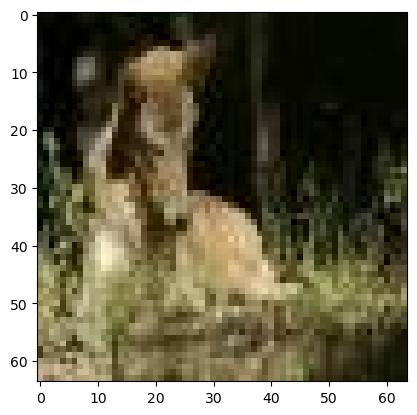

In [2]:
%run data_loader.py

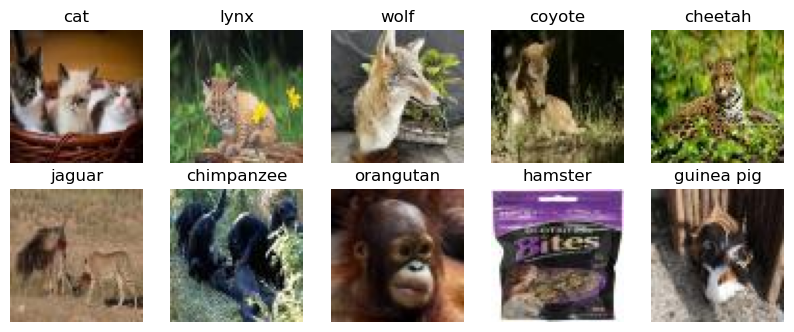

In [3]:
# Define class labels
class_labels = ['cat', 'lynx', 'wolf', 'coyote', 'cheetah', 'jaguar', 'chimpanzee', 'orangutan', 'hamster', 'guinea pig']

# Create a figure to display the images
plt.figure(figsize=(10,10))

# Iterate through each class
for i in range(num_classes):
    # Find the first image of this class
    class_idx = (train_labels == i).nonzero(as_tuple=True)[0][0]
    
    # Display the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[class_idx].permute(1, 2, 0))
    plt.title(class_labels[i])
    plt.axis('off')

plt.show()

- id_bytes = 4
- label_bytes = 4
- num_train_files = 1
- num_train_images = 50000
- width = 64
- height = 64
- depth = 3
- num_classes = 10

## 8. Train a linear model on the animal clasification dataset. Note that you will need to use PyTorch to train this model, since there is no way you'll be able to do the matrix inversion required to run OLS. Here is some https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/linear_regression/main.py. A linear model corresponds to a single linear layer from the input to the output.

- `device`: enabled efficient and flexible execution of PyTorch code providing accelerated computations on `CUDA-enabled GPU` when possible or `cpu`.
- loss function was CrossEntropyLoss(), which was commonnly used for multi-calss classification problmes.
- The optimizer was `Adam`, a varaint of stochastic gradient descent. Compared with `SGD` optimizer, Adam might perform better in larger datasets as it converged faster, might provide faster convergence due to its adpative learning rates, and had fewer hyperparameters to tune compared to SGD that saved time for hyperparameter search.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters
input_size = 64*64*3
output_size = 10
num_epochs = 500
learning_rate = 0.001
batch_size = 100 # batch size for training 
weight_decay = 0.0003

# Load your dataset
## We have train_images and train_labels already


train_images = train_images.to(device).float()
train_labels = train_labels.to(device).long()
val_images = val_images.to(device).float()
val_labels = val_labels.to(device).long()

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(val_images, val_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Linear regression model
model = nn.Linear(input_size, output_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # use CrossEntropyLoss for multi-class classification
## weight_decay for L2 regularization to avoid overfitting problem
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, input_size)

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


Epoch [10/500], Loss: 307.8296
Epoch [20/500], Loss: 340.4066
Epoch [30/500], Loss: 489.1484
Epoch [40/500], Loss: 125.5872
Epoch [50/500], Loss: 259.4930
Epoch [60/500], Loss: 272.8452
Epoch [70/500], Loss: 314.3696
Epoch [80/500], Loss: 310.7984
Epoch [90/500], Loss: 296.6292
Epoch [100/500], Loss: 175.7329
Epoch [110/500], Loss: 174.2720
Epoch [120/500], Loss: 154.3116
Epoch [130/500], Loss: 239.0523
Epoch [140/500], Loss: 281.4898
Epoch [150/500], Loss: 149.1970
Epoch [160/500], Loss: 210.7282
Epoch [170/500], Loss: 172.8715
Epoch [180/500], Loss: 302.3523
Epoch [190/500], Loss: 148.4788
Epoch [200/500], Loss: 95.2155
Epoch [210/500], Loss: 285.2211
Epoch [220/500], Loss: 176.3322
Epoch [230/500], Loss: 515.6531
Epoch [240/500], Loss: 228.3351
Epoch [250/500], Loss: 181.1832
Epoch [260/500], Loss: 233.3981
Epoch [270/500], Loss: 340.7835
Epoch [280/500], Loss: 274.0869
Epoch [290/500], Loss: 223.8100
Epoch [300/500], Loss: 211.1830
Epoch [310/500], Loss: 301.7209
Epoch [320/500], L